# ASE2020 submission id #302 -- iCPD

16-03-2020 XXXXXXXXXXX

We proceed in 5 main steps, using an example of estimating a single unknown transition probability in a DTMC from state i to j, say $p_{ij}$:
1. Simulate a window of runtime data.
2. We run the Imprecise Probability with Sets of Priors (IPSP) Bayesian estimator to plot the runtime estimates of $p_{ij}$ when seeing a sudden change.
3. We introduce a **trigger** of our CPD based on the **prior-data conflict** detection feature of IPSP.
4. Do the CPD analysis, if it is indeed triggered.
5. The new IPSP+CPD run time estimates on $p_{ij}$.

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from scipy.stats import norm

sns.set_style('white')
sns.set_context('talk')

np.random.seed(77)

## 1. Now, the first step is to generate some runtime data

In [2]:
w=1000 #the  window size of the data is w
the_cp = 500 # the ground truth change point in that window

the_a = 0.3 # the ground truth transition probability before cp
data_before_cp = np.random.binomial(1, the_a, the_cp)


the_b = 0.7 # the ground truth transition probability after cp
data_after_cp = np.random.binomial(1, the_b, w-the_cp)

data=np.append(data_before_cp,data_after_cp)
print(data,type(data))
print(np.sum(data[0:the_cp]),np.sum(data[the_cp:w]),np.sum(data),len(data))

[1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0
 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 0 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1
 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0
 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 1 1 1 

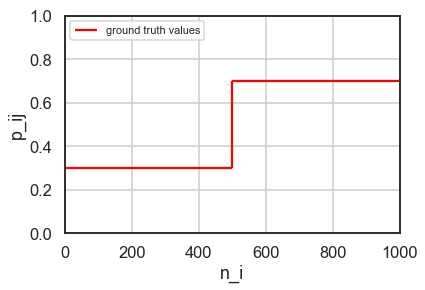

In [3]:
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )
plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)
plt.show()

## 2. Use IPSP to estimate the $p_{ij}$ given the simulated data

In [4]:
# this is the IPSP estimator
def IPSP_est_pij(ni, nij, c_prior_lower, c_prior_upper, mij_prior_lower, mij_prior_upper):
#define function to use sets of priors to update transition probabilityes p_ij (renamed as mij)
#the n_i is the totoal outgoing transitions from state i
#the n_ij is the transtions from i to j.
#the other 4 parameters are defining the set of priors of IPSP
    mij_post_lower=0
    mij_post_upper=0

    if(ni==0):
        return mij_prior_lower, mij_prior_upper
    if(nij/ni) >= mij_prior_lower:
        mij_post_lower=(c_prior_upper*mij_prior_lower+nij)/(c_prior_upper+ni)
        
    if(nij/ni) < mij_prior_lower:
        mij_post_lower=(c_prior_lower*mij_prior_lower+nij)/(c_prior_lower+ni)
        
    if (nij/ni) <= mij_prior_upper:
        mij_post_upper=(c_prior_upper*mij_prior_upper+nij)/(c_prior_upper+ni)
        
    if (nij/ni) > mij_prior_upper:
        mij_post_upper=(c_prior_lower*mij_prior_upper+nij)/(c_prior_lower+ni)

    return mij_post_lower, mij_post_upper

In [5]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=10
n_prior_upper=300
pij_prior_lower=0.2
pij_prior_upper=0.4

current_epoch=1
while current_epoch<len(data):
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[0:current_epoch])
    n_ij=sum(data[0:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1

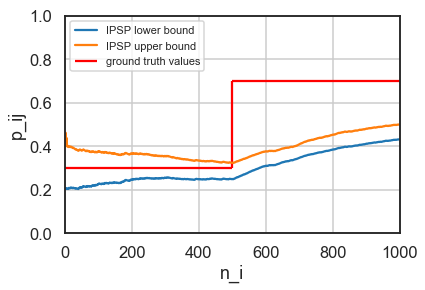

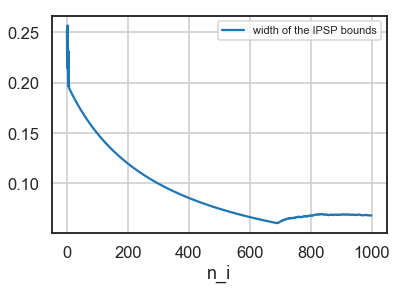

In [6]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(IPSP_est_lower, label='IPSP lower bound',linestyle='-')
plt.plot(IPSP_est_upper, label='IPSP upper bound',linestyle='-')

plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()

plt.plot(np.array(IPSP_est_diff),label='width of the IPSP bounds')
plt.legend(loc='upper right',fontsize=11)
plt.xlabel('n_i')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


## 3. The trigger of CPD

In [7]:

the_tp=0# the trigger point
current_epoch=1 #the trigger point only 
while current_epoch<len(data)-1:
    #if current width is bigger than 1.05 * the minimum width seen so far
    #1.05 the threshold factor that can be changed by experts.
    if current_epoch>100 and IPSP_est_diff[current_epoch]-IPSP_est_diff[current_epoch-1]>0:
        the_tp=current_epoch
        break
    current_epoch=current_epoch+1

In [8]:
#now the window of the data is from 0 to the_tp
if the_tp==0:
    print('no CPD analysis is triigred')
else:
    w=the_tp
    print('the tirgier point is at {}'.format(w))
    tp1=w

the tirgier point is at 690


## 4. The CPD analysis

Now let us define our likelihood function

In [9]:
def N(x):
    # return the number of transitions before the x point 
    return np.sum(data[0:x])
     
def M(x):
    # return the number of transitions after the x point 
    return np.sum(data[x:w])

def likelihood(x):
    # simply the binomial likelihood, maybe better to use log- to increase the precision..
    #x=int(x)
    a=np.float64(N(x)/x)
    b=np.float64(M(x)/(w-x))# note, here w!=x..
    return (a**(N(x)))*((1-a)**(x-N(x)))*(b**M(x))*((1-b)**(w-x-M(x)))
    

print(likelihood(the_cp-30),likelihood(w-1))

4.122387268637225e-182 5.267300953772004e-202


Now let us do MCMC samplings...

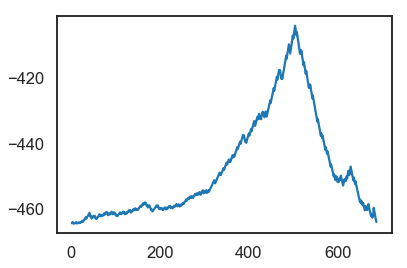

In [10]:

#this code is to visualise the likelihood
def h(b):
    l = []
    for i in b:
        l.append(math.log(likelihood(i)))
    return l
t = np.arange(2, w-2, 1)
plt.plot(t, h(t))
plt.show()


## Ok, now lets analysis the overheads of MCMC as a function of the sample size..

In [11]:
import timeit
import time

## this part is used to capture return value with Python timeit module
##cf. https://stackoverflow.com/questions/24812253/how-can-i-capture-return-value-with-python-timeit-module

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

In [12]:
## A warmup example...


def f(x,y):
    a=x*y+10
    return a 

x = 5
y = 7

print(timeit.timeit(stmt='f(x,y)',
                    setup='from __main__ import f, x, y',
                    number=100))

(2.0099999999523277e-05, 45)


In [13]:
def MCMC(w,num_samples,tuning_parameter):
    samples= num_samples# number of samples
    std= tuning_parameter#the std of the proposal dist. which needs to be fine tuned
    test=[1]
    x_current = round(w/2) #starting point of MCMC
    x_posterior=[x_current] 
    for i in range(samples):
    # step 1: from a symetrical normal dist., sample a proposed x
        proposal = np.random.normal(x_current, std, 1) 
    
        while proposal[0]<0 or proposal[0]>w: #the proposal x cannot be out of the data window..
            proposal = np.random.normal(x_current, std, 1)

        proposal=int(proposal[0])

    #step 2: let us decide if we accpet that proposal or not.
        likelihood_current =likelihood(x_current)
        likelihood_proposal =likelihood(proposal)

    # Compute prior probability of current and proposed x        
        prior_current = 1/w #here we assume prior x is unifomly distributed, but you can use others\\
        prior_proposal = 1/w # for sure, then you change here..

    # Nominator of Bayes formula
        p_current = likelihood_current #* prior_current
        p_proposal = likelihood_proposal #* prior_proposal

        p_accept = p_proposal / p_current
    

        accept = np.random.rand() < p_accept
        test.append(accept) # record the number of proposals being accpeted for fine tune.

    # if accpet then change the x_current and put the accpected sample in to posterior

        if accept:
    # Update position
            x_current = proposal
            x_posterior.append(x_current)  
    return np.mean(x_posterior), sum(test)

#print(x_posterior,test)

In [14]:

MCMC_time=np.array([])
MCMC_mean_x_post=np.array([])
MCMC_num_accepted_samples=np.array([]) # i.e. k in the paper..

i=500

while i<15000:
    
    num_samples=i
    tuning_parameter=9


    temp=timeit.timeit(stmt='MCMC(w,num_samples,tuning_parameter)',
                    setup='from __main__ import MCMC, w, num_samples,tuning_parameter',
                    number=1)
    #print(temp[0], temp[1][0],temp[1][1])
    MCMC_time=np.append(MCMC_time,temp[0])
    MCMC_mean_x_post=np.append(MCMC_mean_x_post,temp[1][0])
    MCMC_num_accepted_samples=np.append(MCMC_num_accepted_samples,temp[1][1])
    i=i+100

In [15]:
MCMC_time=MCMC_time*1000  ## change the time unit into ms
print(len(MCMC_time))

145


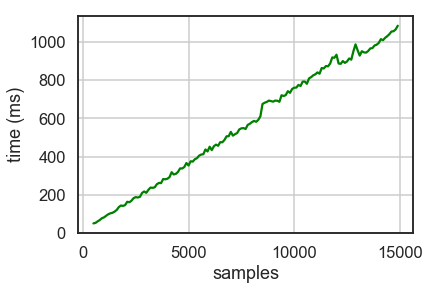

In [16]:
i=500
x_index=np.array([])
while i<15000:
    x_index =np.append(x_index,i)
    i=i+100
## Above is to rescale the x axis; Note need to have the same setup with the loop above...

plt.plot(x_index,MCMC_time,linestyle='-',color='green')

#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis
#plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('samples')
plt.ylabel('time (ms)')
plt.grid(True)

plt.show()

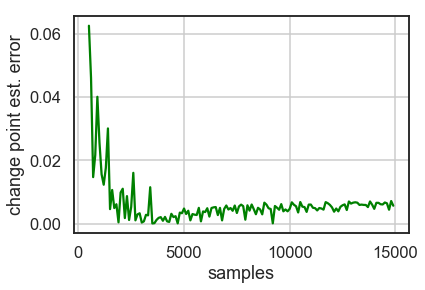

In [17]:
plt.plot(x_index,abs(MCMC_mean_x_post-the_cp)/the_cp,linestyle='-',color='green')

#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis
#plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('samples')
plt.ylabel('change point est. error')
plt.grid(True)
plt.yscale("linear")

plt.show()

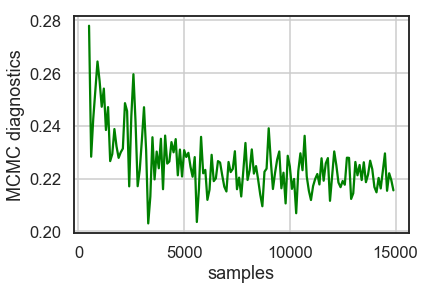

In [18]:
plt.plot(x_index,np.divide(MCMC_num_accepted_samples,x_index),linestyle='-',color='green')

#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis
#plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('samples')
plt.ylabel('MCMC diagnostics')
plt.grid(True)
plt.yscale("linear")

plt.show()

## now let us do another example using long data window

In [19]:
w=1000 #the  window size of the data is w
the_cp = 500 # the ground truth change point in that window

the_a = 0.3 # the ground truth transition probability before cp
data_before_cp = np.random.binomial(1, the_a, the_cp)


the_b = 0.5 # the ground truth transition probability after cp
data_after_cp = np.random.binomial(1, the_b, w-the_cp)

data=np.append(data_before_cp,data_after_cp)
print(data,type(data))
print(np.sum(data[0:the_cp]),np.sum(data[the_cp:w]),np.sum(data),len(data))

[0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0
 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 0 1 1 0 0 0
 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 0 0
 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0
 1 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0
 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0
 0 0 0 1 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0
 1 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1
 1 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1
 0 0 0 0 1 0 0 0 0 0 1 0 

In [20]:
IPSP_est_upper=[]
IPSP_est_lower=[]
IPSP_est_diff=[] #the difference between the lower and upper bounds

#the 4 parameters defining the sets of priors
n_prior_lower=10
n_prior_upper=300
pij_prior_lower=0.2
pij_prior_upper=0.4

current_epoch=1
while current_epoch<len(data):
    #fisrt, statistics on n_i and n_ij
    n_i=len(data[0:current_epoch])
    n_ij=sum(data[0:current_epoch])
    
    temp_lower, temp_upper=IPSP_est_pij(n_i,n_ij,n_prior_lower,n_prior_upper,pij_prior_lower,pij_prior_upper)
    #print(temp_lower, temp_upper)
    IPSP_est_lower.append(temp_lower)
    IPSP_est_upper.append(temp_upper)
    IPSP_est_diff.append(temp_upper-temp_lower)
    current_epoch=current_epoch+1
    

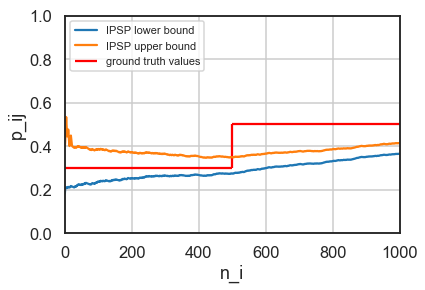

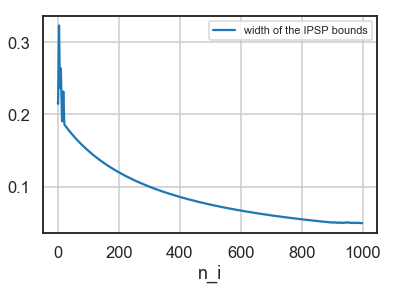

In [21]:
#Now let us do the plot
plt.hlines(y=the_a,xmin=0,xmax=the_cp,
           color='r', linestyle='-',label='ground truth values')
plt.hlines(y=the_b,xmin=the_cp,xmax=w,
           color='r',linestyle='-' )
plt.vlines(x=the_cp,ymin=the_a,ymax=the_b,
           color='r',linestyle='-' )

plt.plot(IPSP_est_lower, label='IPSP lower bound',linestyle='-')
plt.plot(IPSP_est_upper, label='IPSP upper bound',linestyle='-')

plt.axis([0, w, 0, 1])# set the ranges of axis
plt.legend(loc='upper left',fontsize=11)
plt.xlabel('n_i')
plt.ylabel('p_ij')
plt.grid(True)

plt.show()

plt.plot(np.array(IPSP_est_diff),label='width of the IPSP bounds')
plt.legend(loc='upper right',fontsize=11)
plt.xlabel('n_i')
#plt.ylabel('p_ij')
plt.grid(True)
plt.show()


In [22]:
the_tp=0# the trigger point
current_epoch=1 #the trigger point only 
while current_epoch<len(data)-1:
    #if current width is bigger than 1.05 * the minimum width seen so far
    #1.05 the threshold factor that can be changed by experts.
    if current_epoch>100 and IPSP_est_diff[current_epoch]-IPSP_est_diff[current_epoch-1]>0:
        the_tp=current_epoch
        break
    current_epoch=current_epoch+1

    #now the window of the data is from 0 to the_tp
if the_tp==0:
    print('no CPD analysis is triigred')
else:
    w=the_tp
    print('the tirgier point is at {}'.format(w))
    tp2=w

the tirgier point is at 885


In [23]:
MCMC_time2=np.array([])
MCMC_mean_x_post2=np.array([])
MCMC_num_accepted_samples2=np.array([]) # i.e. k in the paper..

i=500

while i<15000:
    
    num_samples=i
    tuning_parameter=109


    temp=timeit.timeit(stmt='MCMC(w,num_samples,tuning_parameter)',
                    setup='from __main__ import MCMC, w, num_samples,tuning_parameter',
                    number=1)
    #print(temp[0], temp[1][0],temp[1][1])
    MCMC_time2=np.append(MCMC_time2,temp[0])
    MCMC_mean_x_post2=np.append(MCMC_mean_x_post2,temp[1][0])
    MCMC_num_accepted_samples2=np.append(MCMC_num_accepted_samples2,temp[1][1])
    i=i+100

In [24]:
MCMC_time2=MCMC_time2*1000  ## change the time unit into ms
print(len(MCMC_time2))

145


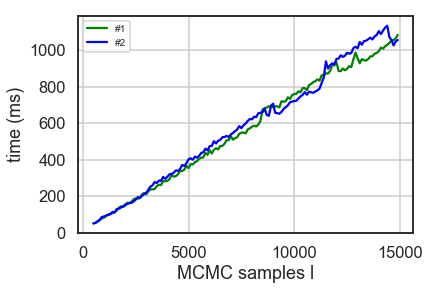

In [28]:
i=500
x_index=np.array([])
while i<15000:
    x_index =np.append(x_index,i)
    i=i+100
## Above is to rescale the x axis; Note need to have the same setup with the loop above...

plt.plot(x_index,MCMC_time,linestyle='-',color='green', label='#1')
plt.plot(x_index,MCMC_time2,linestyle='-',color='blue',label='#2')

#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis

#plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.legend(fontsize=10)
plt.xlabel('MCMC samples l')
plt.ylabel('time (ms)')
plt.grid(True)

plt.show()

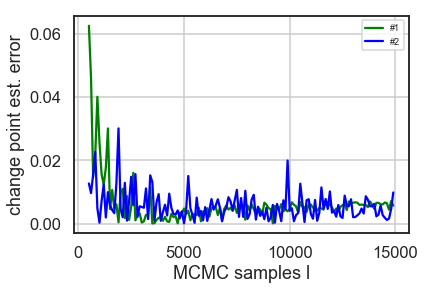

In [26]:
plt.plot(x_index,abs(MCMC_mean_x_post-the_cp)/the_cp,linestyle='-',color='green',label='#1')

plt.plot(x_index,abs(MCMC_mean_x_post2-the_cp)/the_cp,linestyle='-',color='blue',label='#2')
#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis
plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('MCMC samples l')
plt.ylabel('change point est. error')
plt.grid(True)
plt.yscale("linear")

plt.show()

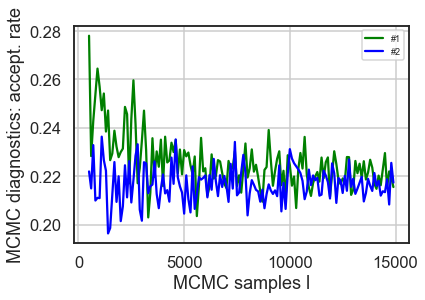

In [27]:
plt.plot(x_index,np.divide(MCMC_num_accepted_samples,x_index),linestyle='-',color='green',label='#1')

plt.plot(x_index,np.divide(MCMC_num_accepted_samples2,x_index),linestyle='-',color='blue',label='#2')
#plt.plot(x_index[w:],IPSP_est_upper[w:],linestyle='dotted',color='purple',label='IPSP upper bound')

#plt.axis([1, len(MCMC_time), 0, np.max(MCMC_time)])# set the ranges of axis
plt.legend(fontsize=9,bbox_to_anchor=(1,1))
plt.xlabel('MCMC samples l')
plt.ylabel('MCMC diagnostics: accept. rate')
plt.grid(True)
plt.yscale("linear")

plt.show()